In [2]:
import multiprocessing
multiprocessing.set_start_method('fork', force=True)

In [3]:
import pandas as pd
import numpy as np
import ast
import json
from typing import Optional, Tuple

def get_balanced_samples(df: pd.DataFrame, 
                        n_per_class: Optional[int] = None,
                        train_fraction: float = 0.8,
                        random_state: Optional[int] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Randomly sample an equal number of records where hallucinated is True and False,
    split into training and test sets, and format prompts for each row.
    
    Args:
        df (pd.DataFrame): Input DataFrame with 'hallucinated', 'question', and 'options' columns
        n_per_class (int, optional): Number of samples to take from each class.
                                   If None, uses the size of the smaller class.
        train_fraction (float): Fraction of data to use for training (default: 0.8)
        random_state (int, optional): Random seed for reproducibility
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (train_df, test_df) containing balanced samples
                                         with formatted prompts
    """
    if not 0 < train_fraction < 1:
        raise ValueError("train_fraction must be between 0 and 1")
    
    # Ensure hallucinated column is boolean
    df = df.copy()

    # Filter by activation if the column exists
    if 'activation' in df.columns:
        original_len = len(df)
        df = df[df['activation'] == 0]
        filtered_len = len(df)

        if filtered_len == 0:
            raise ValueError("No rows remaining after filtering activation = 0")

    # Ensure hallucinated column is boolean
    df['hallucinated'] = df['hallucinated'].astype(bool)
    
    # Split into True and False groups
    true_samples = df[df['hallucinated'] == True]
    false_samples = df[df['hallucinated'] == False]
    
    # Get counts
    n_true = len(true_samples)
    n_false = len(false_samples)
    
    # If n_per_class not specified, use size of smaller group
    if n_per_class is None:
        n_per_class = min(n_true, n_false)
    
    # Verify we have enough samples
    if n_per_class > min(n_true, n_false):
        raise ValueError(f"Requested {n_per_class} samples per class but smallest class only has {min(n_true, n_false)} samples")
    
    # Sample from each group
    sampled_true = true_samples.sample(n=n_per_class, random_state=random_state)
    sampled_false = false_samples.sample(n=n_per_class, random_state=random_state)
    
    # Calculate number of training samples (ensuring even split between classes)
    n_train_per_class = int(n_per_class * train_fraction)
    
    # Split each class into train and test
    train_true = sampled_true.iloc[:n_train_per_class]
    test_true = sampled_true.iloc[n_train_per_class:]
    
    train_false = sampled_false.iloc[:n_train_per_class]
    test_false = sampled_false.iloc[n_train_per_class:]
    
    # Combine and shuffle train and test sets
    train_df = pd.concat([train_true, train_false])
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    test_df = pd.concat([test_true, test_false])
    test_df = test_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    
    # Format prompts for both datasets
    def format_prompts(df):
        introduction = ("You are a medical expert and this is a multiple choice exam question. "
                       "Please respond with the integer index of the CORRECT answer only; [0,1,2,3].")
        
        formatted_df = df.copy()
        formatted_prompts = []
        
        for _, row in df.iterrows():
            question = row['question']
            
            # Parse options
            if isinstance(row['options'], str):
                options_dict = ast.literal_eval(row['options'])
            elif isinstance(row['options'], list) and len(row['options']) > 0:
                options_dict = row['options'][0]
            else:
                options_dict = row['options']
            
            # Filter out 'correct answer' from options
            options_filtered = {k: v for k, v in options_dict.items() if k != 'correct answer'}
            options_formatted = "Options: " + json.dumps(options_filtered)
            
            # Construct prompt
            prompt = f"{introduction}\n\n{question}\n\n{options_formatted}"
            formatted_prompts.append(prompt)
        
        formatted_df['prompt'] = formatted_prompts
        return formatted_df
    
    # Apply prompt formatting to both datasets
    train_df = format_prompts(train_df)
    test_df = format_prompts(test_df)
    
    print(f"Created balanced samples with {n_per_class} records per class")
    print(f"Training set: {len(train_df)} records ({n_train_per_class} per class)")
    print(f"Test set: {len(test_df)} records ({n_per_class - n_train_per_class} per class)")
    print("\nClass distribution in training set:")
    print(train_df['hallucinated'].value_counts())
    print("\nClass distribution in test set:")
    print(test_df['hallucinated'].value_counts())
    
    return train_df, test_df

In [4]:
file_path = '../data/baseline_results.tsv'

# Read the TSV file
df = pd.read_csv(file_path, sep='\t')

# Get balanced samples with train/test split
train_data, val_data = get_balanced_samples(
    df=df,
    n_per_class=1172,
    train_fraction=0.8,
    random_state=42
)


Created balanced samples with 1172 records per class
Training set: 1874 records (937 per class)
Test set: 470 records (235 per class)

Class distribution in training set:
hallucinated
False    937
True     937
Name: count, dtype: int64

Class distribution in test set:
hallucinated
True     235
False    235
Name: count, dtype: int64


In [5]:
print("total number of records:", len(df))
print("hallucinated:", df['hallucinated'].sum())
print("proportion hallucinated:",  df['hallucinated'].sum()/len(df))

total number of records: 8600
hallucinated: 1720
proportion hallucinated: 0.2


In [6]:
df.shape, train_data.shape, val_data.shape

((8600, 10), (1874, 10), (470, 10))

In [7]:
import goodfire as gf
import os

# Get API key
api_key = os.getenv('GOODFIRE_API_KEY')
client  = gf.Client(api_key)
variant = gf.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

In [8]:
import pandas as pd 
from typing import List, Tuple


# 1. Prepare Dataset
def prepare_dataset(train_data: pd.DataFrame, hallucinated: bool=True) -> Tuple[List, pd.DataFrame]: 
  """Prepare a dataset from training data based on hallucinated or truthful examples. 
  Args:
      train_data (pd.DataFrame): DataFrame containing training data with 'hallucinated' and 'prompt' columns.
      hallucinated (bool): Boolean indicating whether to filter for hallucinated examples.
  Returns:
        tuple: A tuple containing:
            - dataset (list): A list of conversations in the required format for each example.
            - filtered_examples (pd.DataFrame): The filtered DataFrame containing only the examples 
                                                corresponding to the specified hallucinated value.
  """
  filtered_examples = train_data[train_data['hallucinated'] == hallucinated]
  dataset = [
    [
      {"role": "user", "content": prompt},
      {"role": "assistant", "content": "3"} 
    ] for prompt in filtered_examples["prompt"].tolist()
  ]
  return dataset, filtered_examples


# 2. Chunk Dataset
def chunk_dataset(dataset, chunk_size=64): 
  """
    Split a dataset into smaller chunks for API processing.
    Args:
        dataset: The dataset to chunk.
        chunk_size: Maximum size of each chunk.
    Yields:
        Chunks of the dataset.
    """
  for i in range(0, len(dataset), chunk_size):
    yield dataset[i:i+chunk_size]
    

# 3. Contrast Features
def contrast_features(client, variant, dataset_1_chunks, dataset_2_chunks, top_k=50):
  """
    Perform feature contrast for two datasets using Goodfire.
    Args:
        client: The Goodfire client instance.
        variant: The model variant to use.
        dataset_1_chunks: List of dataset chunks for the first class.
        dataset_2_chunks: List of dataset chunks for the second class.
        top_k: Number of top features to extract.
    Returns:
        A tuple of feature groups for dataset_1 and dataset_2.
    """ 
  hallucinated_features = None  # Initialize to None
  truthful_features = None 
  
  for d1_chunk, d2_chunk in zip(dataset_1_chunks, dataset_2_chunks):
    hallucinated_chunk_features, truthful_chunk_features = client.features.contrast(
      dataset_1=d1_chunk, 
      dataset_2=d2_chunk, 
      model=variant, 
      top_k=top_k
    )
    if hallucinated_features is None:
        hallucinated_features = hallucinated_chunk_features
    else:
        hallucinated_features = hallucinated_features.union(hallucinated_chunk_features)

    if truthful_features is None:
        truthful_features = truthful_chunk_features
    else:
        truthful_features = truthful_features.union(truthful_chunk_features)

  return hallucinated_features, truthful_features
  


# 4. Rerank Features
def rerank_features(client, features, query, model, top_k=50):
  """
  Rerank features based on a query.
  Args:
      client: The Goodfire client instance.
      features: The features to rerank.
      query: Query string for reranking.
      model: The model variant to use.
      top_k: Number of top features to return.
  Returns:
      Reranked features.
  """
  return client.features.rerank(
    features=features,
    query=query,
    model=model,
    top_k=top_k
  )
  
  
# 5. Combine Features 
def combine_features(hallucinated_features, truthful_features):
  """
  Combine two sets of features into a single set.
  Args:
      hallucinated_features: Features from the hallucinated dataset.
      truthful_features: Features from the truthful dataset.
  Returns:
      A combined set of features.
  """
  return hallucinated_features | truthful_features

In [9]:
# Step 1: Prepare datasets
dataset_1, hallucinated_examples = prepare_dataset(train_data, hallucinated=True)
dataset_2, truthful_examples = prepare_dataset(train_data, hallucinated=False)

_, hallucinated_examples_test = prepare_dataset(val_data, hallucinated=True)
_, truthful_examples_test = prepare_dataset(val_data, hallucinated=False)

# Step 2: Chunk datasets
chunk_size = 64
dataset_1_chunks = list(chunk_dataset(dataset_1, chunk_size))
dataset_2_chunks = list(chunk_dataset(dataset_2, chunk_size))

# Step 3: Contrast features
hallucinated_features, truthful_features = contrast_features(
    client,
    variant,
    dataset_1_chunks,
    dataset_2_chunks,
    top_k=100
)

# Step 4: Rerank features
hallucinated_features = rerank_features(
    client,
    hallucinated_features,
    query="response is inconsistent with medical evidence",
    model=variant,
    top_k=50
)

truthful_features = rerank_features(
    client,
    truthful_features,
    query="response adheres to clinical evidence",
    model=variant,
    top_k=50
)

# Step 5: Combine features
features_to_look_at = combine_features(hallucinated_features, truthful_features)

# Final Output
print(features_to_look_at)

FeatureGroup([
   0: "Neural innervation and control in medical contexts",
   1: "Start of new conversation segment requiring ethical consistency",
   2: "Dental and oral health educational content",
   3: "Start of potentially sensitive conversation segments requiring moderation",
   4: "Start of potentially sensitive conversations requiring moderation",
   5: "Start of conversations requiring ethical oversight",
   6: "Reset conversation and maintain ethical boundaries",
   7: "Start of new conversation, particularly those requiring ethical oversight",
   8: "Beginning of new conversation segment or topic change",
   ...
   68: "Medical content about cardiovascular conditions and treatments"
])


In [10]:
import pickle

# Save the data to a file
def save_feature_activations(name: str, feature_activations):
  with open(f"../data/{name}.pkl", "wb") as f:
      pickle.dump(feature_activations, f)
      
save_feature_activations('features_to_look_at', features_to_look_at)

In [11]:
truthful_features

FeatureGroup([
   0: "Evidence-based therapeutic techniques being explained by the assistant",
   1: "Physical examination findings and documentation in medical notes",
   2: "Medical history sections and references in clinical documentation",
   3: "Medical history documentation patterns in clinical settings",
   4: "Calcium channel blockers and other cardiovascular medications",
   5: "Medical treatment recommendations and follow-up instructions in clinical notes",
   6: "Patient demographic introductions in clinical notes",
   7: "Patient history and symptom description in clinical documentation",
   8: "Biological regulatory relationships and mechanisms of action",
   ...
   49: "Medical content about cardiovascular conditions and treatments"
])

In [12]:
hallucinated_features

FeatureGroup([
   0: "Neural innervation and control in medical contexts",
   1: "Start of new conversation segment requiring ethical consistency",
   2: "Dental and oral health educational content",
   3: "Start of potentially sensitive conversation segments requiring moderation",
   4: "Start of potentially sensitive conversations requiring moderation",
   5: "Start of conversations requiring ethical oversight",
   6: "Reset conversation and maintain ethical boundaries",
   7: "Start of new conversation, particularly those requiring ethical oversight",
   8: "Beginning of new conversation segment or topic change",
   ...
   18: "Start of a new conversation or chat segment"
])

In [13]:
async_client = gf.AsyncClient(api_key=api_key, base_url="https://api.goodfire.ai")

In [14]:
import pandas as pd
import asyncio
from tqdm.asyncio import tqdm_asyncio
import httpx

MIN_SAMPLES_PER_CLASS = min(
    len(hallucinated_examples),
    len(truthful_examples),
)

async def inspect_with_retry(client, prompt, model, features, retries=3, delay=2):
    """
    Inspect features with retry logic.
    
    Args:
        client: The async client instance.
        prompt: The prompt to send to the model.
        model: The model to use.
        features: The feature group to inspect.
        retries: Maximum number of retries.
        delay: Delay between retries in seconds.
    
    Returns:
        The response from the inspect call.
    """
    for attempt in range(retries):
        try:
            return await client.features.inspect(
                [
                    {"role": "user", "content": f"{prompt}"},
                    {"role": "assistant", "content": "3"}
                ],
                model=model,
                features=features,
            )
        except (httpx.ConnectError, httpx.ReadTimeout) as e:
            print(f"Retry {attempt + 1}/{retries} for prompt '{prompt}' failed with error: {e}")
            if attempt < retries - 1:
                await asyncio.sleep(delay)
            else:
                raise

async def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: gf.FeatureGroup,
    k=100,
    batch_size=200,
    retries=3,
    delay=2
):
    if k < len(features_to_use_for_classification):
        raise ValueError(
            "k must be greater than the number of features to use for classification"
        )

    samples = []
    all_samples = sample_class[0:MIN_SAMPLES_PER_CLASS]

    # Process in batches
    for i in range(0, len(all_samples), batch_size):
        batch = all_samples[i:i + batch_size]
        tasks = []

        for idx, row in batch.iterrows():
            prompt = row["prompt"]
            tasks.append(
                inspect_with_retry(
                    async_client,
                    prompt,
                    model=variant,
                    features=features_to_use_for_classification,
                    retries=retries,
                    delay=delay
                )
            )

        # Process this batch
        batch_results = await tqdm_asyncio.gather(*tasks, desc=f"Processing batch {i // batch_size + 1}")
        for context in batch_results:
            features = context.top(k=k)
            samples.append(features)

    return samples

async def process_all_classes():
    print("Computing truthful features...")
    truthful_feat_act = await _get_feature_acts_for_sample_class(
        truthful_examples, features_to_look_at, k=100
    )

    print("Computing hallucinated features...")
    hallucinated_feat_act = await _get_feature_acts_for_sample_class(
        hallucinated_examples, features_to_look_at, k=100
    )

    return truthful_feat_act, hallucinated_feat_act

# Run the processing
truthful_feat_act, hallucinated_feat_act = await process_all_classes()


Computing truthful features...


Processing batch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Processing batch 5:   7%|▋         | 9/137 [00:06<00:54,  2.35it/s]

Retry 1/3 for prompt 'You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].

Cholesterol is following what vitamins (Vitamin) synthetic precursor?

Options: {"0": "A", "1": "D", "2": "IS", "3": "TO"}' failed with error: [Errno 8] nodename nor servname provided, or not known


Processing batch 5: 100%|██████████| 137/137 [00:13<00:00, 10.05it/s]


Computing hallucinated features...


Processing batch 1:  66%|██████▌   | 132/200 [00:15<00:00, 77.57it/s]

Retry 1/3 for prompt 'You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].

Why subunits is protein kinase A dependent on cyclic AMP ?:

Options: {"0": "4 regulatory subunits.", "1": "2 regulatory and 2 catalytic subunits.", "2": "3 regulatory subunits and 1 catalytic subunit.", "3": "4 catalytic subunits."}' failed with error: [Errno 8] nodename nor servname provided, or not known


Processing batch 5: 100%|██████████| 137/137 [00:11<00:00, 11.49it/s]


### Extracting feature activation for test set

In [15]:
async def process_all_classes():
    print("Computing truthful features...")
    truthful_feat_act_test = await _get_feature_acts_for_sample_class(
        truthful_examples_test, features_to_look_at, k=100
    )

    print("Computing hallucinated features...")
    hallucinated_feat_act_test = await _get_feature_acts_for_sample_class(
        hallucinated_examples_test, features_to_look_at, k=100
    )
    
    return truthful_feat_act_test, hallucinated_feat_act_test
    
truthful_feat_act_test, hallucinated_feat_act_test = await process_all_classes()

Computing truthful features...


Processing batch 1:   2%|▎         | 5/200 [00:06<03:28,  1.07s/it]

Retry 1/3 for prompt 'You are a medical expert and this is a multiple choice exam question. Please respond with the integer index of the CORRECT answer only; [0,1,2,3].

From the following options indicate which option is CERTAIN as a contraindication in vaccination:

Options: {"0": "Be on antibiotic treatment at that time.", "1": "Be convalescing from a mild illness", "2": "Corticoterapia of short duration.", "3": "Decompensated cardiopathies."}' failed with error: [Errno 8] nodename nor servname provided, or not known


Processing batch 2: 100%|██████████| 35/35 [00:05<00:00,  5.94it/s]


Computing hallucinated features...


Processing batch 2: 100%|██████████| 35/35 [00:04<00:00,  7.57it/s]


In [16]:
len(truthful_feat_act[0]), len(hallucinated_feat_act[0])

(89, 89)

In [17]:
import pickle

# Save the data to a file
def save_feature_activations(name: str, feature_activations):
  with open(f"../data/{name}.pkl", "wb") as f:
      pickle.dump(feature_activations, f)


save_feature_activations("truthful_feat_act", truthful_feat_act)
save_feature_activations("hallucinated_feat_act", hallucinated_feat_act)

save_feature_activations("truthful_feat_act_test", truthful_feat_act_test)
save_feature_activations("hallucinated_feat_act_test", hallucinated_feat_act_test)





In [18]:
import pickle
# Load the data from a file
def load_feature_activations(name: str):
  with open(f"../data/{name}.pkl", "rb") as f:
      activations = pickle.load(f)
  return activations

truthful_feat_act = load_feature_activations('truthful_feat_act')
hallucinated_feat_act = load_feature_activations('hallucinated_feat_act')

truthful_feat_act_test = load_feature_activations('truthful_feat_act_test')
hallucinated_feat_act_test = load_feature_activations('hallucinated_feat_act_test')

features_to_look_at = load_feature_activations('features_to_look_at')



### Feature Selection

#### 1. Grid Search

In [19]:
from itertools import combinations


class FeatureSearch:
    """A class for systematically searching through 
      combinations of features to evaluate their predictive power.
    """

    def __init__(self, feature_group):
        self.feature_group = feature_group

    def grid(self, k_features_per_combo: int = 2):
        """Perform a grid search over all possible combinations of features.
        Args:
            k_features_per_combo (int): The number of features to include in each combination.
        Returns:
            list: All possible k-sized combinations of features from the feature group.
        """

        # Get all possible combinations of features
        return list(combinations(self.feature_group, k_features_per_combo))

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score


# Grid search may take a while, you can curate the feature list to speed this process up significantly

def train_tree(x, y, depth):
  train_x, test_x, train_y, test_y = train_test_split(
    x, y, train_size=0.8, random_state=42, stratify=y)

  # Create a nice regularized tree
  model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    max_features=2,
    min_samples_leaf=max(len(train_x) // 20, 1),
    # max_leaf_nodes=2,
    # min_samples_leaf=10,
    splitter='best',
    random_state=1
  )

  model.fit(train_x, train_y)
  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  f1 = f1_score(test_y, pred)
  precision = precision_score(test_y, pred, pos_label=1)
  recall = recall_score(test_y, pred, pos_label=1)
  
  metrics = {
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
    }

  return model, pred, metrics

In [23]:
import numpy as np
from itertools import combinations
from math import comb
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm


def preprocess_features(class_features, features):
    feature_to_index = {feature.uuid: idx for idx, feature in enumerate(features)}
    data = np.zeros((len(class_features), len(features)), dtype=np.float32)
    for i, row in enumerate(class_features):
        for feature_act in row:
            if feature_act.feature.uuid in feature_to_index:
                data[i, feature_to_index[feature_act.feature.uuid]] = feature_act.activation
    return data


def evaluate_combinations(X, y, combos, feature_to_index):
    best_score = 0
    best_combo = None
    best_model = None

    for combo in combos:
        indices = [feature_to_index[feature] for feature in combo]
        X_subset = X[:, indices]
        
        model, _, metrics = train_tree(X_subset, y, depth=len(combo))
        if metrics['f1_score'] > best_score:
            best_score = metrics['f1_score']
            best_combo = combo
            best_model = model
        
    return best_combo, best_score, best_model


def find_best_combo(features, X, y, k_features_per_combo=3, max_workers=4):
    feature_list = list(features)
    feature_to_index = {feature: idx for idx, feature in enumerate(feature_list)}
    combos = FeatureSearch(features).grid(k_features_per_combo=k_features_per_combo)

    # Chunk combinations dynamically
    chunk_size = max(len(combos) // (max_workers * 10), 1)
    combo_chunks = [combos[i:i + chunk_size] for i in range(0, len(combos), chunk_size)]

    best_combo = None
    best_score = 0
    best_model = None

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(
            tqdm(
                executor.map(
                    evaluate_combinations,
                    [X] * len(combo_chunks),
                    [y] * len(combo_chunks),
                    combo_chunks,
                    [feature_to_index] * len(combo_chunks),
                ),
                total=len(combo_chunks),
                desc="Feature Search",
            )
        )

    # Find the best result across all chunks
    for combo, score, model in results:
        if score > best_score:
            best_combo, best_score, best_model = combo, score, model

    return best_combo, best_score, best_model


# Preprocess data
x_hallucinated = preprocess_features(hallucinated_feat_act, features_to_look_at)
x_truthful = preprocess_features(truthful_feat_act, features_to_look_at)
y_hallucinated = np.ones(len(x_hallucinated), dtype=np.int32)
y_truthful = np.zeros(len(x_truthful), dtype=np.int32)
X = np.vstack((x_hallucinated, x_truthful))
y = np.concatenate((y_hallucinated, y_truthful))

# Run grid search
best_combo_at_k = {}
for k in range(1, 5):
    best_combo, best_score, best_model = find_best_combo(
        features_to_look_at, X, y, k_features_per_combo=k, max_workers=4
    )
    print(f"k={k}: Best Combo={best_combo}, Best Score={best_score:.4f}")
    best_combo_at_k[k] = (best_combo, best_score, best_model)

Feature Search: 100%|██████████| 69/69 [00:00<00:00, 1001.11it/s]

k=1: Best Combo=(Feature("Patient history and symptom description in clinical documentation"),), Best Score=0.6982



Feature Search: 100%|██████████| 41/41 [00:01<00:00, 22.84it/s]

k=2: Best Combo=(Feature("Start of new conversation segment requiring ethical consistency"), Feature("Patient history and symptom description in clinical documentation")), Best Score=0.6982



Feature Search: 100%|██████████| 41/41 [00:38<00:00,  1.05it/s]


k=3: Best Combo=(Feature("Patient history and symptom description in clinical documentation"), Feature("References to patients in formal healthcare documentation"), Feature("Medical symptom descriptions and disease progression patterns")), Best Score=0.7004


Feature Search: 100%|██████████| 41/41 [10:24<00:00, 15.22s/it]

k=4: Best Combo=(Feature("Patient demographic introductions in clinical notes"), Feature("Medical descriptions of eye conditions and ophthalmic treatments"), Feature("Medical report negation of concerning findings"), Feature("Public health messaging promoting vaccine safety and uptake")), Best Score=0.7033


In [24]:
best_combo_at_k[4]

((Feature("Patient demographic introductions in clinical notes"),
  Feature("Medical descriptions of eye conditions and ophthalmic treatments"),
  Feature("Medical report negation of concerning findings"),
  Feature("Public health messaging promoting vaccine safety and uptake")),
 0.7032520325203252,
 DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=2,
                        min_samples_leaf=74, random_state=1))

In [26]:
for k in [1, 2, 3, 4]:
    combo, score, model = best_combo_at_k[k]
    print(f"k={k} features: score={score}")
    


k=1 features: score=0.6982248520710059
k=2 features: score=0.6982248520710059
k=3 features: score=0.7004048582995951
k=4 features: score=0.7032520325203252


In [27]:
best_individual_feature = best_combo_at_k[4][0][0]
best_individual_feature

Feature("Patient demographic introductions in clinical notes")

In [28]:
feature_grp = client.features.neighbors(best_individual_feature, model="meta-llama/Meta-Llama-3.1-8B-Instruct" )
feature_grp

FeatureGroup([
   0: "Connective phrases in formal medical case presentations",
   1: "Medical symptom progression and duration descriptions",
   2: "The assistant is gathering information about someone's condition or status in a professional context",
   3: "Section headers and formatting boundaries in structured documents",
   4: "Section headers and structural elements in clinical documentation, especially SOAP notes",
   5: "Medical case narrative flow and symptom progression documentation",
   6: "Medical comorbidities and condition combinations",
   7: "Medical history sections and references in clinical documentation",
   8: "Medical treatment recommendations and follow-up instructions in clinical notes",
   9: "Vital signs measurements in medical documentation"
])

In [30]:
BEST_TREE_INDEX = 4
best_features_combo = best_combo_at_k[BEST_TREE_INDEX][0]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

best_features_combo, best_tree

((Feature("Patient demographic introductions in clinical notes"),
  Feature("Medical descriptions of eye conditions and ophthalmic treatments"),
  Feature("Medical report negation of concerning findings"),
  Feature("Public health messaging promoting vaccine safety and uptake")),
 DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=2,
                        min_samples_leaf=74, random_state=1))

In [31]:
import goodfire
import json

def save_features(features: goodfire.FeatureGroup, json_path):
    features_data = features.json()
    with open(json_path, 'w') as f:
        json.dump(features_data, f, indent=4)

In [32]:
best_features_combo = goodfire.FeatureGroup(best_features_combo)
best_features_combo

FeatureGroup([
   0: "Patient demographic introductions in clinical notes",
   1: "Medical descriptions of eye conditions and ophthalmic treatments",
   2: "Medical report negation of concerning findings",
   3: "Public health messaging promoting vaccine safety and uptake"
])

In [33]:


save_features(best_features_combo, '../data/best_features_combo')

#### 2. Feature Importance

In [34]:
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

#### Feature Selection

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
import numpy as np


class GeneralFeatureSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, selection_method, model, n_features_to_select=3, **kwargs):
        self.selection_method = selection_method
        self.model = model
        self.n_features_to_select = n_features_to_select
        self.kwargs = kwargs
        self.selector = None
        

    def fit(self, X, y):
        if self.selection_method == "rfe":
            self.selector = RFE(self.model, n_features_to_select=self.n_features_to_select)
        elif self.selection_method == "sfs":
            self.selector = SequentialFeatureSelector(
                self.model,
                n_features_to_select=self.n_features_to_select,
                **self.kwargs
            )
        elif self.selection_method == "importance":
            self.model.fit(X, y)
            importances = self.model.feature_importances_
            self.selector = np.argsort(importances)[::-1][:self.n_features_to_select]
            return self
        else:
            raise ValueError(f"Unknown selection method: {self.selection_method}")
        
        self.selector.fit(X, y)
        return self
      

    def transform(self, X):
        if self.selection_method == "importance":
            return X[:, self.selector]
        else:
            return X[:, self.selector.get_support(indices=True)]
          

    def get_selected_features(self, feature_names):
        if self.selection_method == "importance":
            return [feature_names[int(i)] for i in self.selector]
        else:
            return [feature_names[int(i)] for i in self.selector.get_support(indices=True)]
          
    def get_selected_feature_indices(self):
        if self.selection_method in ["rfe", "sfs"]:
            return self.selector.get_support(indices=True)
        elif self.selection_method == "importance":
            return self.selector
        else:
            raise ValueError(f"Unknown selection method: {self.selection_method}")

In [36]:
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Define the parameter grid
param_grid = {
    'classification__criterion': ['gini', 'entropy'],
    'feature_selection__n_features_to_select': [3, 5],
    'classification__max_depth': [3, 4, 5, 6],
    'classification__max_features': [None, 4, 5],
    'classification__min_samples_leaf': [5, 10, 20],
    'classification__splitter': ['best', 'random']
}

scoring_metrics = {
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
}

# Feature selection methods
methods = ["rfe", "sfs", "importance"]

# To store results
results_dict = []

for method in methods:
    print(f"Evaluating {method}...")
    pipeline = Pipeline([
        ('feature_selection', GeneralFeatureSelector(
            selection_method=method,
            model=DecisionTreeClassifier(),
            n_features_to_select=3
        )),
        ('classification', DecisionTreeClassifier())
    ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring_metrics,
        refit='f1',  # Refit the model based on the F1 score
        n_jobs=-1
    )
    grid_search.fit(X, y)

    # Get best parameters
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Get selected features and their indices
    best_pipeline = grid_search.best_estimator_
    selector = best_pipeline.named_steps['feature_selection']
    selected_indices = selector.get_selected_feature_indices()  # Modify to use your selector's method
    selected_features = [features_to_look_at[int(i)] for i in selected_indices]
    
    results_dict.append({
        "method": method,
        "best_params": best_params,
        "best_score": best_score,
        "selected_indices": selected_indices,
        "selected_features": selected_features,
        "accuracy": grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]
    })
    print(f"Best params for {method}: {best_params}")
    print(f"Best score for {method}: {best_score:.4f}")
    print(f"Selected Features for {method}: {selected_features}\n")

# Convert results to a DataFrame
results_df = pd.DataFrame(results_dict)

# Display the results DataFrame
print(results_df)



Evaluating rfe...
Best params for rfe: {'classification__criterion': 'gini', 'classification__max_depth': 3, 'classification__max_features': 5, 'classification__min_samples_leaf': 20, 'classification__splitter': 'random', 'feature_selection__n_features_to_select': 5}
Best score for rfe: 0.6970
Selected Features for rfe: [Feature("Neural innervation and control in medical contexts"), Feature("Patient demographic introductions in clinical notes"), Feature("Medical case narrative flow and symptom progression documentation"), Feature("Medical symptom descriptions and disease progression patterns"), Feature("Medical report terminology and structural patterns")]

Evaluating sfs...
Best params for sfs: {'classification__criterion': 'gini', 'classification__max_depth': 3, 'classification__max_features': 5, 'classification__min_samples_leaf': 20, 'classification__splitter': 'random', 'feature_selection__n_features_to_select': 5}
Best score for sfs: 0.6807
Selected Features for sfs: [Feature("La

In [37]:
best_features_rfe = goodfire.FeatureGroup(results_df[results_df['method'] == 'rfe']['selected_features'].values[0])
best_features_rfe

FeatureGroup([
   0: "Neural innervation and control in medical contexts",
   1: "Patient demographic introductions in clinical notes",
   2: "Medical case narrative flow and symptom progression documentation",
   3: "Medical symptom descriptions and disease progression patterns",
   4: "Medical report terminology and structural patterns"
])

In [38]:
save_features(best_features_rfe, '../data/best_features_rfe')

In [39]:
results_df.to_csv('../data/feature_selection_results.csv', index=False) # Correct

In [40]:
import pandas as pd 

results_df = pd.read_csv('../data/feature_selection_results.csv')
results_df.head()

,method,best_params,best_score,selected_indices,selected_features,accuracy
0,rfe,"{'classification__criterion': 'gini', 'classif...",0.697011,[ 0 25 32 59 63],"[Feature(""Neural innervation and control in me...",0.602453
1,sfs,"{'classification__criterion': 'gini', 'classif...",0.680674,[31 43 53 56 64],"[Feature(""Laboratory test results and their cl...",0.575778
2,importance,"{'classification__criterion': 'gini', 'classif...",0.688908,[25 2 0],"[Feature(""Patient demographic introductions in...",0.594983


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Split data into training and testing sets
train_x_selected = train_x[:, selected_features_indices]  # Selected feature indices from feature selection
test_x_selected = test_x[:, selected_features_indices]

# Define the hyperparameter grid for the final model
final_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [5, 10, 20],
    'splitter': ['best', 'random']
}

# Define the final model
final_model = DecisionTreeClassifier(random_state=42)

# Perform grid search with cross-validation
final_grid_search = GridSearchCV(
    final_model,
    final_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    refit=True  # Refit the best model on the entire training data
)

# Train the model
final_grid_search.fit(train_x_selected, train_y)

# Evaluate the best model on the test set
best_model = final_grid_search.best_estimator_
test_predictions = best_model.predict(test_x_selected)

# Metrics
test_accuracy = accuracy_score(test_y, test_predictions)
test_f1_score = f1_score(test_y, test_predictions)

# Print Results
print("Final Model Training Results:")
print(f"Best Parameters: {final_grid_search.best_params_}")
print(f"Best F1 Score (Cross-Validation): {final_grid_search.best_score_:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

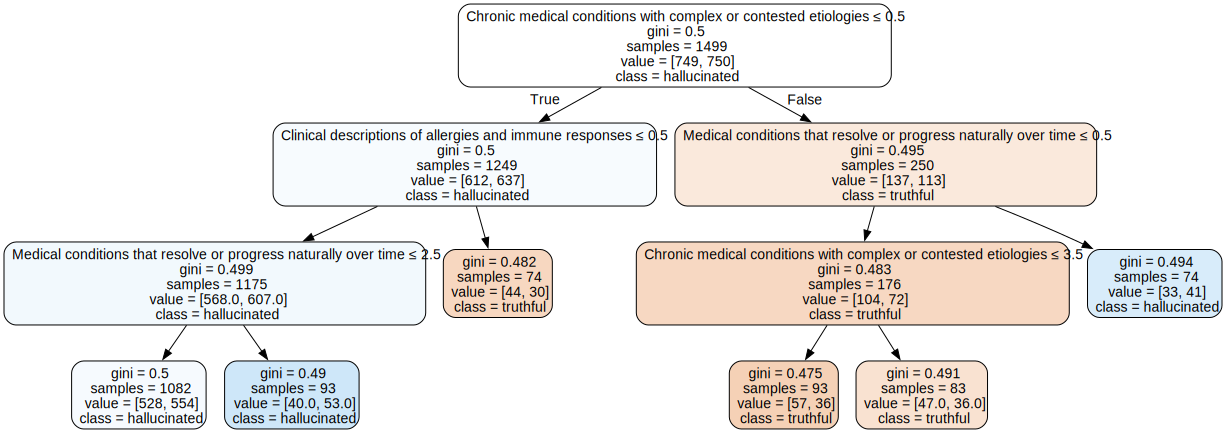

In [33]:
# Let's visualize the tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
  best_tree, 
  out_file=None, 
  feature_names=[feature.label for feature in best_features], 
  class_names=['truthful', 'hallucinated'], 
  filled=True, 
  rounded=True, 
  special_characters=True
  )
graph = graphviz.Source(dot_data)
graph

In [250]:
truthful_feat_act_test, hallucinated_feat_act_test

([FeatureActivations(
     0: (Feature("Patient demographic introductions in clinical notes"), 17)
     1: (Feature("Connective phrases in formal medical case presentations"), 17)
     2: (Feature("Medical test results interpretation and presentation"), 17)
     3: (Feature("Medical assessment scoring systems and their explanatory text"), 12)
     4: (Feature("Medical diagnostic relationships between diseases and symptoms"), 11)
     5: (Feature("Vital signs measurements in medical documentation"), 10)
     6: (Feature("Normal or unremarkable findings in medical reports"), 8)
     7: (Feature("hypertension and blood pressure in medical contexts"), 4)
     8: (Feature("Clinical and medical discussions of female reproductive anatomy"), 3)
     9: (Feature("Medical differential diagnosis consideration and ruling out conditions"), 3)
     ...
     71: (Feature("Variable assignments and value retrievals in calculator code"), 0)
  ),
  FeatureActivations(
     0: (Feature("Vital signs measur

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def extract_feature_activations(client, variant, features, dataset, batch_size=100) -> np.ndarray:
    """
    Extract feature activations for the dataset.
    Args:
        client: The client object to call features.inspect.
        variant: Model variant to use.
        features: List of features to extract activations for.
        dataset (pd.DataFrame): Dataset containing 'prompt' column.
        batch_size (int): Number of prompts to process in each batch.
    Returns:
        np.ndarray: Array of feature activations.
    """
    all_activations = []

    for i in tqdm(range(0, len(dataset), batch_size), desc="Extracting activations"):
        batch = dataset.iloc[i:i + batch_size]
        batch_activations = []

        for prompt in batch['prompt']:
            context = client.features.inspect(
                messages=[{"role": "user", "content": prompt}],
                model=variant,
                features=features
            )
            # Extract activations
            features_dict = {f.uuid: 0.0 for f in features}
            for feature_act in context.top(k=len(features)):
                if feature_act.feature.uuid in features_dict:
                    features_dict[feature_act.feature.uuid] = feature_act.activation

            # Maintain feature order
            activations = [features_dict[f.uuid] for f in features]
            batch_activations.append(activations)

        all_activations.extend(batch_activations)

    return np.array(all_activations)

In [192]:
import pickle
import goodfire as gf
from typing import List, Dict, Tuple, Any
import numpy as np

class HallucinationClassifier:
    def __init__(self, model_path: str, api_key: str):
        """
        Initialize the hallucination classifier with a saved model and features.
        
        Args:
            model_path: Path to the saved pickle file containing both the model and features
            api_key: Goodfire API key for accessing the service
        """
        # Load the model and features
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
            self.model = model_data['model']
            self.features = model_data['features']
        self.client = gf.Client(api_key)
        self.variant = gf.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

    def _format_prompt(self, question: str) -> List[Dict[str, str]]:
        """Format a question into the expected prompt structure."""
        introduction = ("You are a medical expert and this is a multiple choice exam question. "
                      "Please respond with the integer index of the CORRECT answer only; [0,1,2,3].")
        return [{"role": "user", "content": f"{introduction}\n\n{question}"}]
      

    def _get_feature_activations(self, prompt: List[Dict[str, str]]) -> List[float]:
        """Get feature activations for the input prompt."""
        context = self.client.features.inspect(
            messages=prompt,
            model=self.variant,
            features=self.features
        )
        
        # Get activations for our specific features
        activations = []
        features_dict = {f.uuid: 0.0 for f in self.features}
        
        for feature_act in context.top(k=len(self.features)):
            if feature_act.feature.uuid in features_dict:
                features_dict[feature_act.feature.uuid] = feature_act.activation
        
        # Maintain order matching the original features
        for feature in self.features:
            activations.append(features_dict[feature.uuid])
            
        return activations

    def predict(self, question: str, debug: bool = False) -> Tuple[int, float]:
        """
        Predict whether a given question-answer pair is likely to contain hallucination.
        
        Args:
            question: The question text
            debug: If True, print debugging information about feature activations
            
        Returns:
            Tuple containing:
            - Prediction (0 for truthful, 1 for hallucinated)
            - Confidence score (probability of the predicted class)
        """
        # Format the prompt
        prompt = self._format_prompt(question)
        
        # Get feature activations
        activations = self._get_feature_activations(prompt)
        
        if debug:
            print("\nFeature Activations:")
            for feature, activation in zip(self.features, activations):
                print(f"{feature.label}: {activation:.4f}")
            
            # Get the decision path
            decision_path = self.model.decision_path([activations])
            feature_importance = self.model.feature_importances_
            
            print("\nFeature Importance in Model:")
            for feature, importance in zip(self.features, feature_importance):
                print(f"{feature.label}: {importance:.4f}")
            
            print("\nDecision Path:")
            node_indicator = decision_path[0]
            leaf_id = self.model.apply([activations])[0]
            
            # Get thresholds and feature indices for each node in path
            for node_id in node_indicator.indices:
                if node_id != leaf_id:
                    feature_idx = self.model.tree_.feature[node_id]
                    threshold = self.model.tree_.threshold[node_id]
                    feature_name = self.features[feature_idx].label
                    feature_value = activations[feature_idx]
                    print(f"Node {node_id}: {feature_name} = {feature_value:.4f} {'<=' if feature_value <= threshold else '>'} {threshold:.4f}")
        
        # Make prediction
        prediction = self.model.predict([activations])[0]
        probabilities = self.model.predict_proba([activations])[0]
        confidence = probabilities[prediction]
        
        if debug:
            print(f"\nProbabilities:")
            print(f"Truthful: {probabilities[0]:.4f}")
            print(f"Hallucinated: {probabilities[1]:.4f}")
        
        return int(prediction), float(confidence)


In [193]:
def save_model_and_features(model, features, output_path: str):
    """Save both the sklearn decision tree model and Goodfire features to a file.
    
    Args:
        model: The trained sklearn decision tree model
        features: The Goodfire features used by the model
        output_path: Path where to save the pickle file
    """
    model_data = {
        'model': model,
        'features': features
    }
    with open(output_path, 'wb') as f:
        pickle.dump(model_data, f)

In [194]:
# Save the model and best_features

model_path = "hallucination_model.pkl"
save_model_and_features(best_tree, best_features, model_path)



In [6]:
def load_model(model_path):
  with open(model_path, 'rb') as f:
   return pickle.load(f) 
  
model = load_model(model_path=model_path)  

In [195]:
# Initialize the classifier (now simpler, no need to pass features separately)
classifier = HallucinationClassifier(
    model_path=model_path,
    api_key=api_key
)


In [ ]:
clas

In [243]:
# Make predictions - Example from truthful dataframe

prediction, confidence = classifier.predict(example_activations, debug=True)
print("Prediction: ", prediction)
print(f"Prediction: {'Hallucinated' if prediction == 1 else 'Truthful'}")
print(f"Confidence: {confidence:.2f}")


Feature Activations:
Chronic medical conditions with complex or contested etiologies: 3.0000
Normal or unremarkable findings in medical reports: 5.0000
Molecular receptor binding interactions in scientific literature: 3.0000

Feature Importance in Model:
Chronic medical conditions with complex or contested etiologies: 0.1128
Normal or unremarkable findings in medical reports: 0.3269
Molecular receptor binding interactions in scientific literature: 0.5603

Decision Path:
Node 0: Molecular receptor binding interactions in scientific literature = 3.0000 <= 3.5000
Node 1: Normal or unremarkable findings in medical reports = 5.0000 > 4.5000
Node 5: Normal or unremarkable findings in medical reports = 5.0000 <= 9.5000

Probabilities:
Truthful: 0.3462
Hallucinated: 0.6538
Prediction:  1
Prediction: Hallucinated
Confidence: 0.65


## EVALUATION ON TRAIN & TEST DATASETS

In [236]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def evaluate_model_predictions(classifier, truthful_examples, hallucinated_examples):
    """
    Evaluate model predictions across all examples.
    
    Args:
        classifier: The HallucinationClassifier instance
        truthful_examples: DataFrame containing truthful examples
        hallucinated_examples: DataFrame containing hallucinated examples
    """
    # Store results
    results = []
    
    # Process truthful examples
    print("\nProcessing truthful examples...")
    for idx, row in tqdm(truthful_examples.iterrows(), total=len(truthful_examples)):
        prediction, confidence = classifier.predict(row['prompt'])
        results.append({
            'true_label': 'truthful',
            'predicted': 'hallucinated' if prediction == 1 else 'truthful',
            'confidence': confidence
        })
    
    # Process hallucinated examples
    print("\nProcessing hallucinated examples...")
    for idx, row in tqdm(hallucinated_examples.iterrows(), total=len(hallucinated_examples)):
        prediction, confidence = classifier.predict(row['prompt'])
        results.append({
            'true_label': 'hallucinated',
            'predicted': 'hallucinated' if prediction == 1 else 'truthful',
            'confidence': confidence
        })
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Calculate overall statistics
    total_predictions = len(results_df)
    print("\nOverall Statistics:")
    print(f"Total examples evaluated: {total_predictions}")
    
    # Prediction distribution
    pred_dist = results_df['predicted'].value_counts()
    print("\nPrediction Distribution:")
    for pred, count in pred_dist.items():
        percentage = (count/total_predictions) * 100
        print(f"{pred}: {count} ({percentage:.1f}%)")
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    confusion = pd.crosstab(results_df['true_label'], results_df['predicted'])
    print(confusion)
    
    # Calculate metrics by class
    print("\nMetrics by True Label:")
    for label in ['truthful', 'hallucinated']:
        class_results = results_df[results_df['true_label'] == label]
        correct = (class_results['true_label'] == class_results['predicted']).sum()
        total = len(class_results)
        accuracy = (correct/total) * 100
        avg_confidence = class_results['confidence'].mean()
        
        print(f"\n{label.title()} Examples:")
        print(f"Accuracy: {accuracy:.1f}%")
        print(f"Average Confidence: {avg_confidence:.3f}")
    
    # Return the results DataFrame for further analysis if needed
    return results_df


In [255]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd


def predict_row(classifier, features: np.ndarray, true_label: int) -> Dict[str, str]:
    """
    Predict for a single row of feature activations and return the result dictionary.
    Args:
        classifier: The classifier with a `predict_proba` method.
        features (np.ndarray): Feature activations for a single example.
        true_label (int): The true label for the example (0 or 1).
    Returns:
        Dict[str, str]: A dictionary containing the prediction, true label, and confidence.
    """
    # Perform prediction
    predicted_prob = classifier.predict_proba(features.reshape(1, -1))[0]  # Predict probabilities
    prediction = np.argmax(predicted_prob)  # Get the predicted class
    confidence = np.max(predicted_prob)  # Confidence is the highest probability

    return {
        "true_label": "hallucinated" if true_label == 1 else "truthful",
        "predicted": "hallucinated" if prediction == 1 else "truthful",
        "confidence": confidence,
    }


def get_predictions(classifier, X_test: np.ndarray, y_test: np.ndarray):
    """
    Get predictions for all test samples using a classifier.
    Args:
        classifier: The classifier with a `predict_proba` method.
        X_test (np.ndarray): Test feature activations.
        y_test (np.ndarray): True labels for the test data.
    Returns:
        List[Dict[str, str]]: A list of dictionaries containing the predictions.
    """
    return [
        predict_row(classifier, X_test[i], y_test[i])
        for i in tqdm(range(len(X_test)), desc="Evaluating Predictions")
    ]


def calculate_statistics(results_df):
    """
    Calculate statistics and evaluation metrics for the predictions.
    Args:
        results_df (pd.DataFrame): DataFrame containing prediction results.
    Returns:
        Tuple: Total predictions, prediction distribution, confusion matrix, and metrics.
    """
    total_predictions = len(results_df)
    pred_dist = results_df['predicted'].value_counts()
    confusion = pd.crosstab(results_df['true_label'], results_df['predicted'], dropna=False)
    metrics = {}

    for label in ['truthful', 'hallucinated']:
        class_results = results_df[results_df['true_label'] == label]
        total = len(class_results)
        if total > 0:
            correct = (class_results['true_label'] == class_results['predicted']).sum()
            accuracy = (correct / total) * 100
            avg_confidence = class_results['confidence'].mean()
        else:
            accuracy = 0
            avg_confidence = float('nan')
        metrics[label] = {'accuracy': accuracy, 'avg_confidence': avg_confidence}

    return total_predictions, pred_dist, confusion, metrics


def generate_report(total_predictions, pred_dist, confusion, metrics):
    """
    Generate a report for the predictions and evaluation.
    Args:
        total_predictions (int): Total number of predictions made.
        pred_dist (pd.Series): Distribution of predictions.
        confusion (pd.DataFrame): Confusion matrix.
        metrics (dict): Metrics for each class.
    Returns:
        dict: Report containing evaluation results.
    """
    report = {
        "overall_statistics": f"Total examples evaluated: {total_predictions}",
        "prediction_distribution": {
            pred: (count, (count / total_predictions) * 100)
            for pred, count in pred_dist.items()
        },
        "confusion_matrix": confusion.to_dict(orient="index"),
        "metrics": metrics,
    }
    return report


def evaluate_model_predictions(classifier, X_test, y_test):
    """
    Evaluate the classifier's predictions on the test set.
    Args:
        classifier: The classifier with a `predict_proba` method.
        X_test (np.ndarray): Test feature activations.
        y_test (np.ndarray): True labels for the test data.
    Returns:
        Tuple: Results DataFrame and evaluation report.
    """
    predictions = get_predictions(classifier, X_test, y_test)
    results_df = pd.DataFrame(predictions)
    total_predictions, pred_dist, confusion, metrics = calculate_statistics(results_df)
    report = generate_report(total_predictions, pred_dist, confusion, metrics)

    return results_df, report
  

### TRAIN DATASET EVALUATION

In [280]:
best_combo

(Feature("Molecular receptor binding interactions in scientific literature"),)

In [282]:
feature_list = list(features_to_look_at)
feature_to_index = {feature: idx for idx, feature in enumerate(feature_list)}

indices = [feature_to_index[feature] for feature in best_features]
x_hallucinated_test = preprocess_features(hallucinated_feat_act_test, features_to_look_at)
x_truthful_test = preprocess_features(truthful_feat_act_test, features_to_look_at)

x_hallucinated_test_subset = x_hallucinated_test[:, indices]
x_truthful_test_subset = x_truthful_test[:, indices]

y_hallucinated_test = np.ones(len(x_hallucinated_test), dtype=np.int32)
y_truthful_test = np.zeros(len(x_truthful_test), dtype=np.int32)

# Combine the data for both classes
X_test = np.vstack((x_hallucinated_test_subset, x_truthful_test_subset))
y_test = np.concatenate((y_hallucinated_test, y_truthful_test))

In [283]:

X_test.shape

(470, 3)

In [286]:
## TRAINING DATASET EVALUATION

# Assuming classifier is already initialized
results_df, report = evaluate_model_predictions(best_tree, X_test, y_test)

# You can do additional analysis on results_df if needed
# For example, look at high confidence mistakes:
# high_conf_mistakes = results_df[
#     (results_df['true_label'] != results_df['predicted']) & 
#     (results_df['confidence'] > 0.8)
# ]

Evaluating Predictions:   0%|          | 0/470 [00:00<?, ?it/s]

In [293]:
results_df[results_df['true_label'] == "hallucinated"]
results_df[results_df['true_label'] == "truthful"]

,true_label,predicted,confidence
235,truthful,hallucinated,0.653846
236,truthful,hallucinated,0.653846
237,truthful,truthful,0.712121
238,truthful,hallucinated,0.541667
239,truthful,hallucinated,0.541667
...,...,...,...
465,truthful,hallucinated,0.505137
466,truthful,hallucinated,0.541667
467,truthful,truthful,0.712121
468,truthful,hallucinated,0.505137


In [288]:
report

{'overall_statistics': 'Total examples evaluated: 470',
 'prediction_distribution': {'hallucinated': (404, 85.95744680851064),
  'truthful': (66, 14.042553191489363)},
 'confusion_matrix': {'hallucinated': {'hallucinated': 212, 'truthful': 23},
  'truthful': {'hallucinated': 192, 'truthful': 43}},
 'metrics': {'truthful': {'accuracy': np.float64(18.29787234042553),
   'avg_confidence': np.float64(0.5523531573837607)},
  'hallucinated': {'accuracy': np.float64(90.2127659574468),
   'avg_confidence': np.float64(0.533793038788667)}}}

In [26]:
high_conf_mistakes

,true_label,predicted,confidence


### Train Performance Interpretation

The recall of 86% is quite good - the model catches 86% of all hallucinations. This aligns with your goal of preventing medical hallucinations, as it misses relatively few of them.
The precision of 59.7% means that when the model flags something as a hallucination, it's right about 60% of the time. The relatively lower precision indicates that the model is somewhat aggressive in flagging content as hallucinated.
This trade-off (high recall, moderate precision) might be acceptable for the medical use case, as:

In medical contexts, missing a hallucination (false negative) could be more dangerous than incorrectly flagging truthful content (false positive)
False positives can be manually reviewed, while missed hallucinations might go unnoticed

### TEST DATASET EVALUATION